In [1]:
import os
import re
import numpy as np
from scipy.signal import deconvolve
import matplotlib.pyplot as plt
%matplotlib widget

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 100,
})

In [2]:
def getnamelist(path, regex=r'.*\.csv'):
    filenames = os.listdir(path)
    pattern = re.compile(regex)
    return [filename for filename in filenames if pattern.match(filename)]

def getresptime(nameavg,highsample):
    nums = list(map(int, re.findall(r'\d+', nameavg)))
    if highsample:
        path_to_data = '../DataKian/bTa_LT342Chip1/6KIDs_2Pread_673nm_160nW_31dB_4Msample/TD_Power/'
    else:
        path_to_data = '../DataKian/bTa_LT342Chip1/6KIDs_2Pread_673nm_160nW_31dB/TD_Power/'
    with open(path_to_data+'KID'+str(nums[0])+'_'+str(nums[1])+'dBm__TDmed_TmK'+str(nums[2])+'_info.dat','r') as file:
        lines = file.readlines()
    line3=lines[2].strip()
    line4=lines[3].strip()
    F0 = float(re.findall(r"\d*\.?\d+",line3)[0]) * 1000 #from Ghz to us-1
    Quality = float(re.findall(r"\d*\.?\d+",line4)[0])
    tau_ringing = Quality/(np.pi*F0)
    return tau_ringing

def getdict(datapath, namelistavg, namelistinf, dt,highsample):
    pathlistavg = [datapath+nameavg for nameavg in namelistavg]
    pathlistinf = [datapath+nameinf for nameinf in namelistinf]
    dictlist = []
    for pathavg,pathinf,nameavg in zip(pathlistavg,pathlistinf,namelistavg):
        data = np.genfromtxt(pathavg,skip_header=1,delimiter=',')
        t=np.arange(len(data[:,0]))*dt
        tau_ringing = getresptime(nameavg,highsample)
        ringing = np.exp(-t/tau_ringing)
        ringing /= np.sum(ringing)
        dictlist.append({
            'amp': deconvolve(np.pad(data[:,0],(0,len(t)-1),constant_values=0),ringing)[0], #data[:,0],
            'ampstd': data[:,1],
            'phase': deconvolve(np.pad(data[:,2],(0,len(t)-1),constant_values=0),ringing)[0], #data[:,2],
            'phasestd': data[:,3],
            'prominences': np.genfromtxt(pathinf,skip_header=1,delimiter=',')[:,2],
            't': t
            })
    return dict(zip(namelistavg,dictlist))

In [3]:
data1Mpath = '../DataKian/bTa_LT342Chip1/673nm/'
data4Mpath = '../DataKian/bTa_LT342Chip1/673nm/4Msample/'

In [4]:
avg1M = getnamelist(data1Mpath,r'.*_avgpulse_ampphase\.csv')
avg4M = getnamelist(data4Mpath,r'.*_avgpulse_ampphase\.csv')
info1M = getnamelist(data1Mpath,r'.*_avgpulse_ampphase_info\.csv')
info4M = getnamelist(data4Mpath,r'.*_avgpulse_ampphase_info\.csv')


In [5]:
all_data = {
    'data1M': getdict(data1Mpath,avg1M,info1M,dt=1,highsample = False),
    'data4M': getdict(data4Mpath,avg4M,info4M,dt=0.25,highsample = True)
}

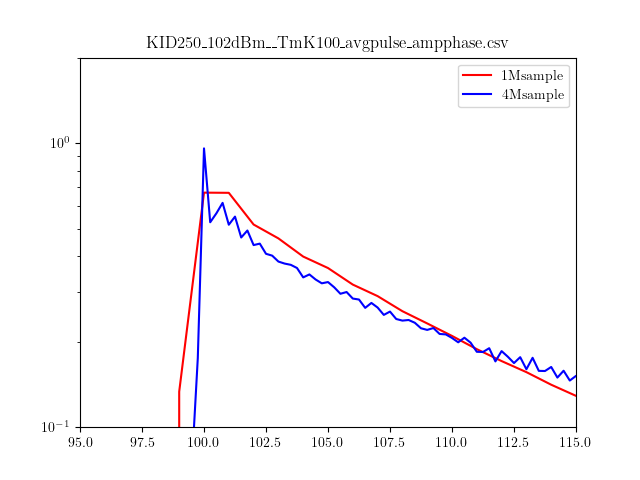

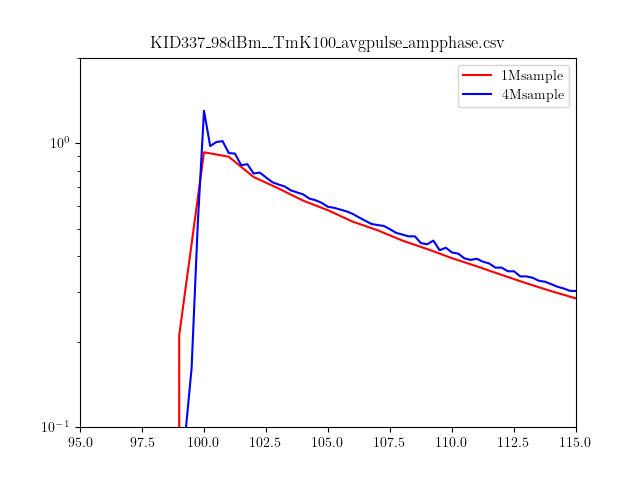

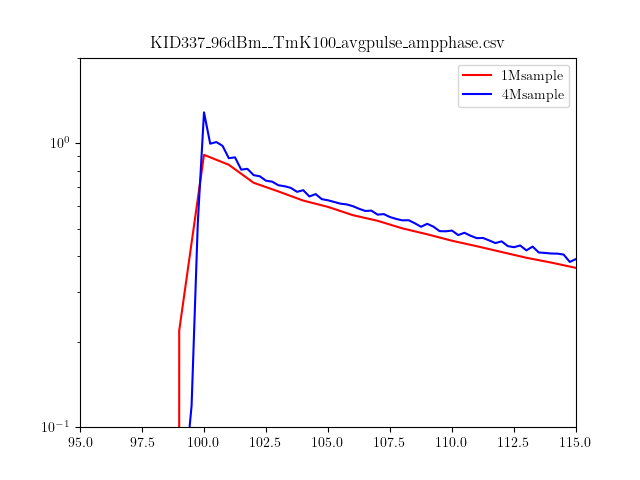

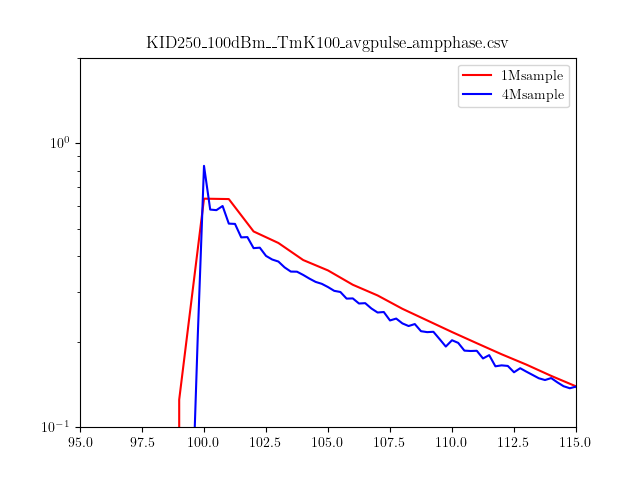

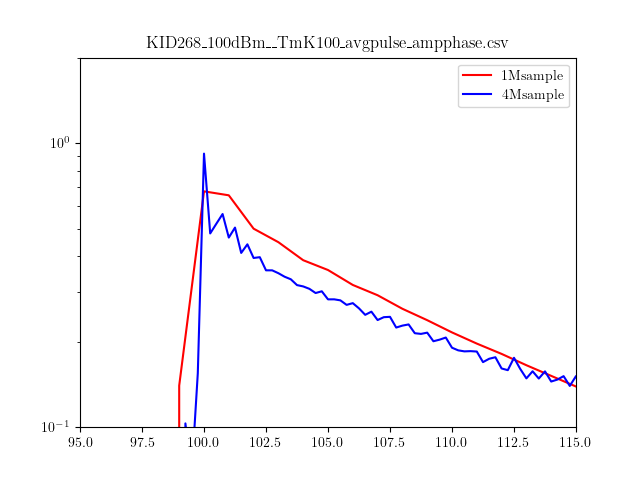

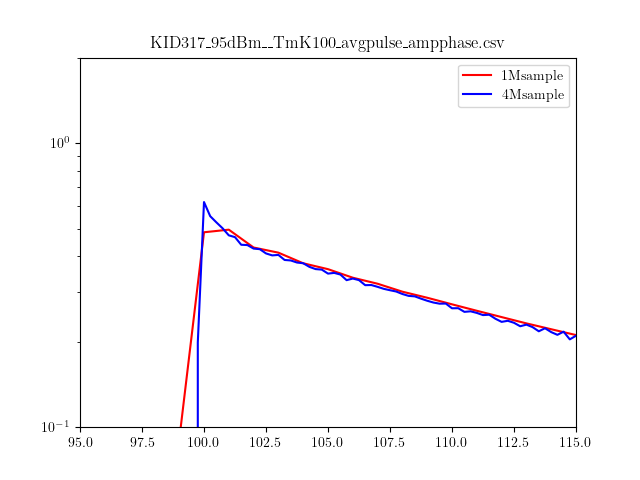

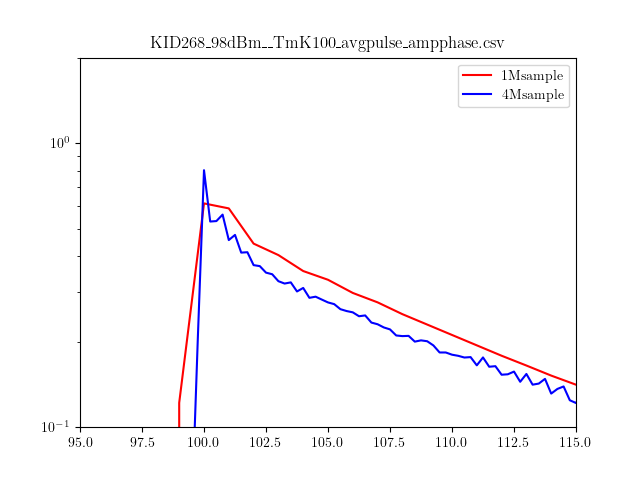

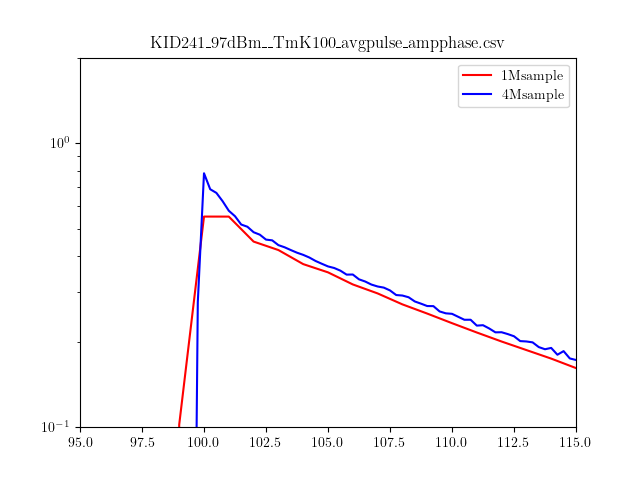

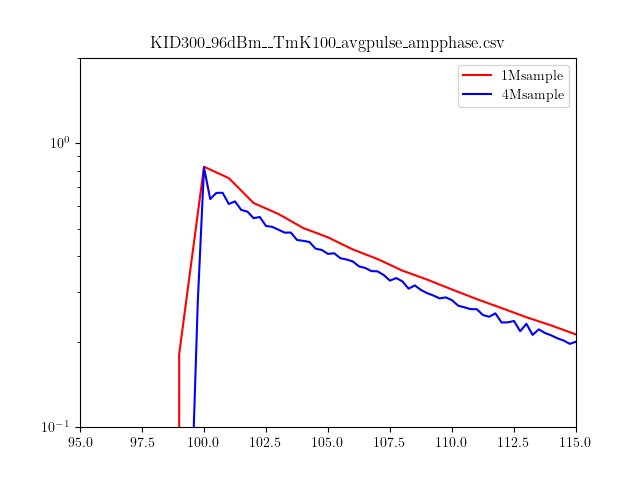

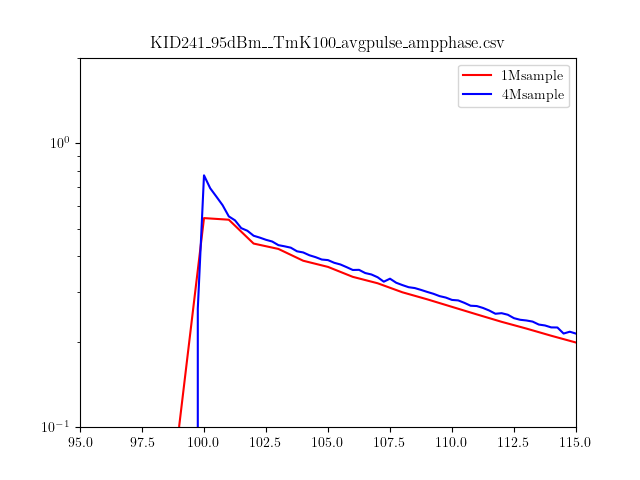

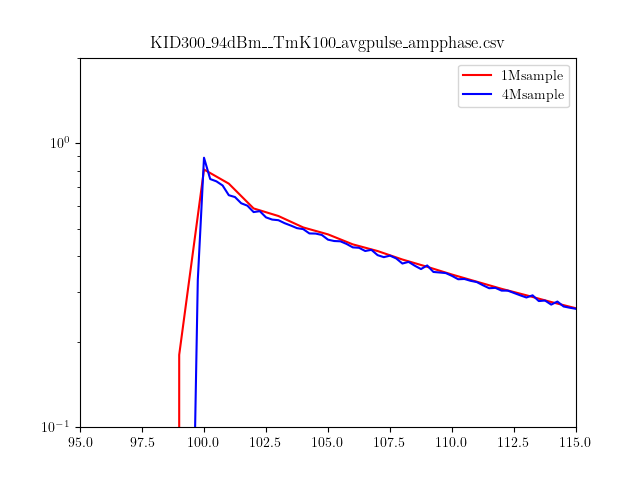

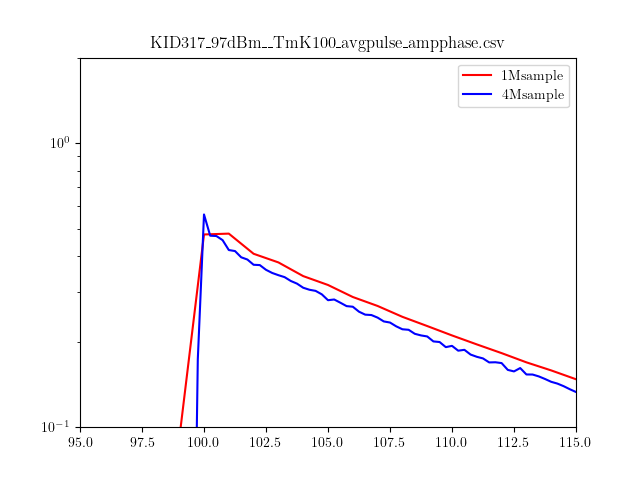

In [6]:
for name in avg1M:
    series1M = all_data['data1M'][name]['phase']
    stddev1M = all_data['data1M'][name]['phasestd']
    series4M = all_data['data4M'][name]['phase']
    stddev4M = all_data['data4M'][name]['phasestd']
    t1M = all_data['data1M'][name]['t']
    t4M = all_data['data4M'][name]['t']
    plt.figure()
    plt.title(name)
    plt.semilogy(t1M,series1M,label='1Msample',color='r')
    #plt.fill_between(t1M, series1M-stddev1M, series1M+stddev1M,color='r',alpha=0.1)
    plt.semilogy(t4M,series4M,label='4Msample',color='b')
    #plt.fill_between(t4M, series4M-stddev4M, series4M+stddev4M,color='b',alpha=0.1)
    plt.xlim(95,115)
    plt.ylim(0.1,2)
    plt.legend()
    plt.show()

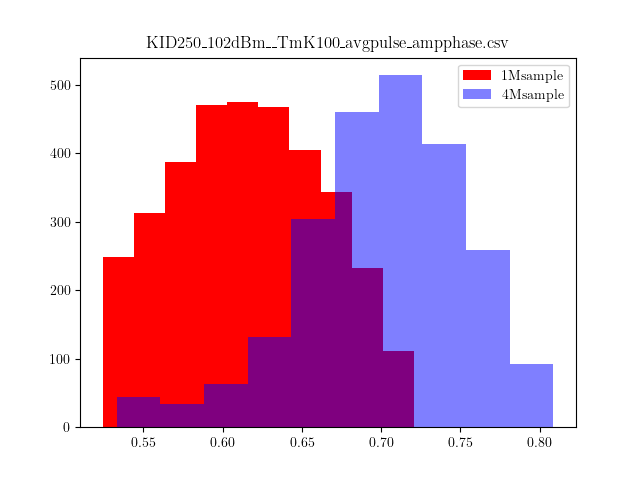

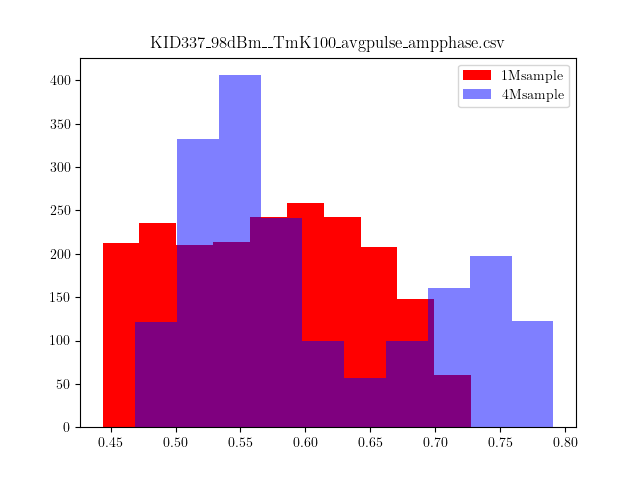

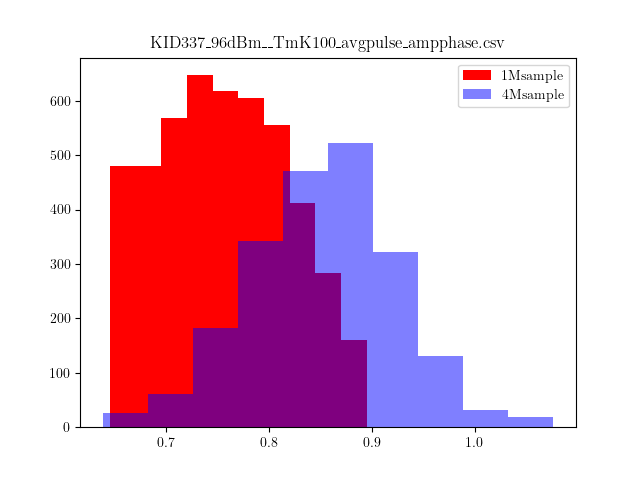

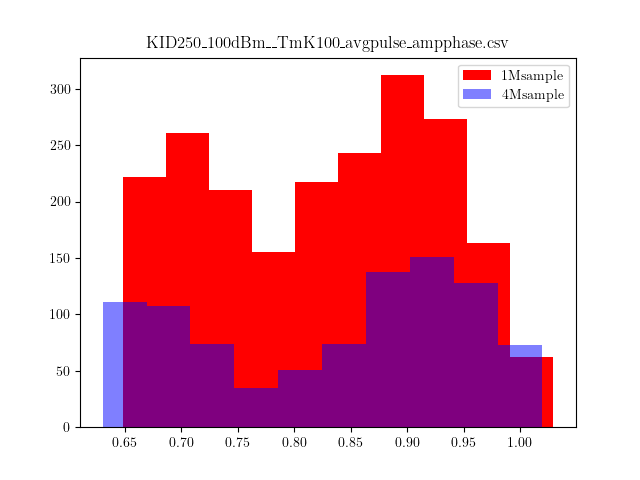

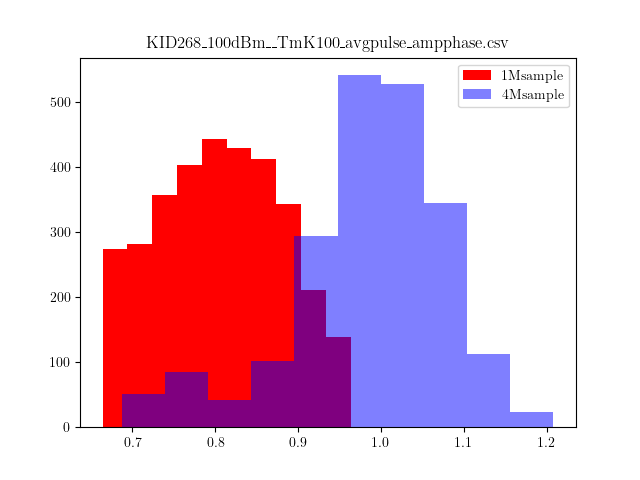

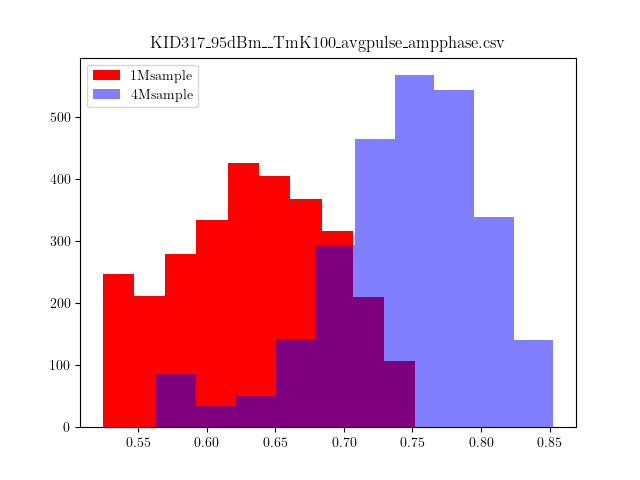

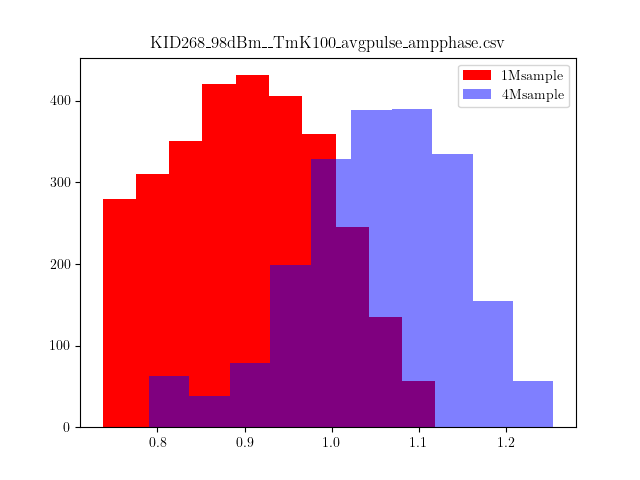

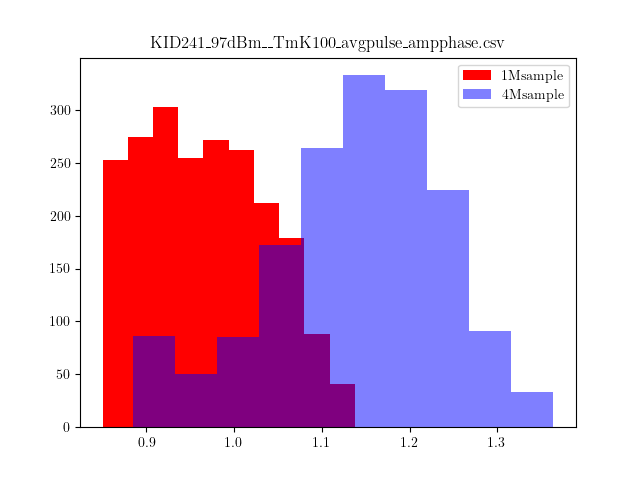

/tmp/ipykernel_10388/1161230759.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


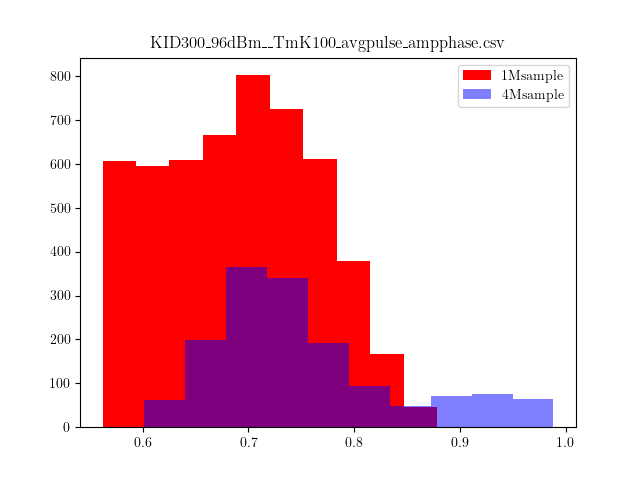

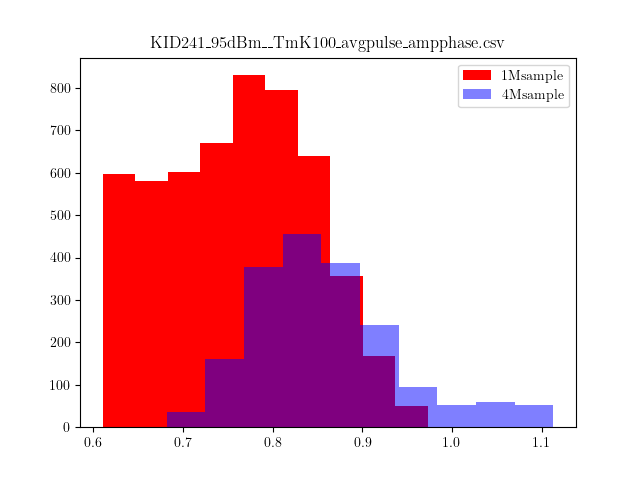

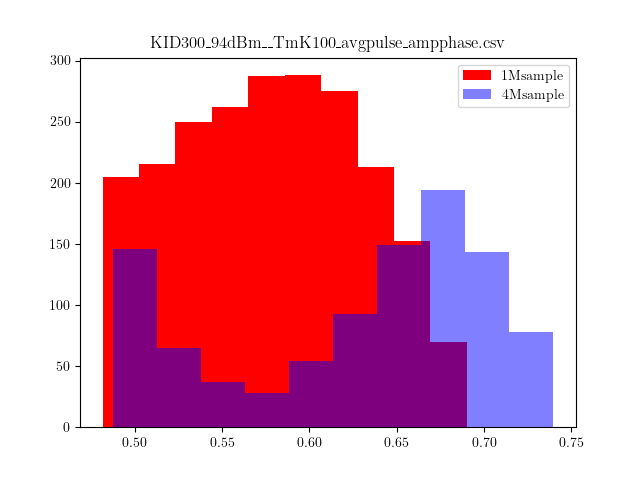

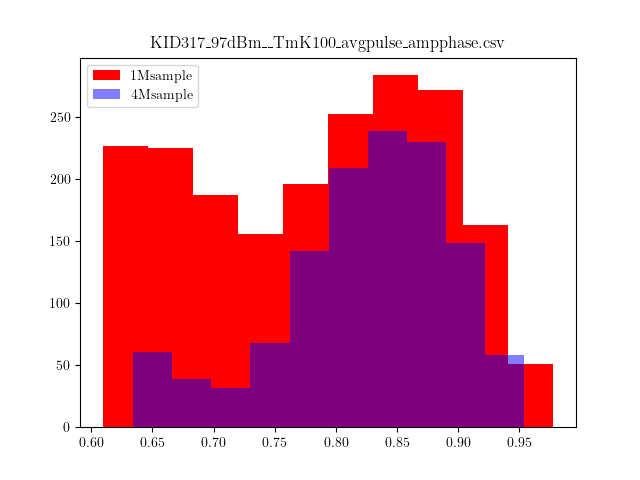

In [7]:
for name in avg1M:
    plt.figure()
    plt.title(name)
    plt.hist(all_data['data1M'][name]['prominences'],label='1Msample',color='r')
    plt.hist(all_data['data4M'][name]['prominences'],label='4Msample',color='b',alpha=0.5)
    plt.legend()
    plt.show()